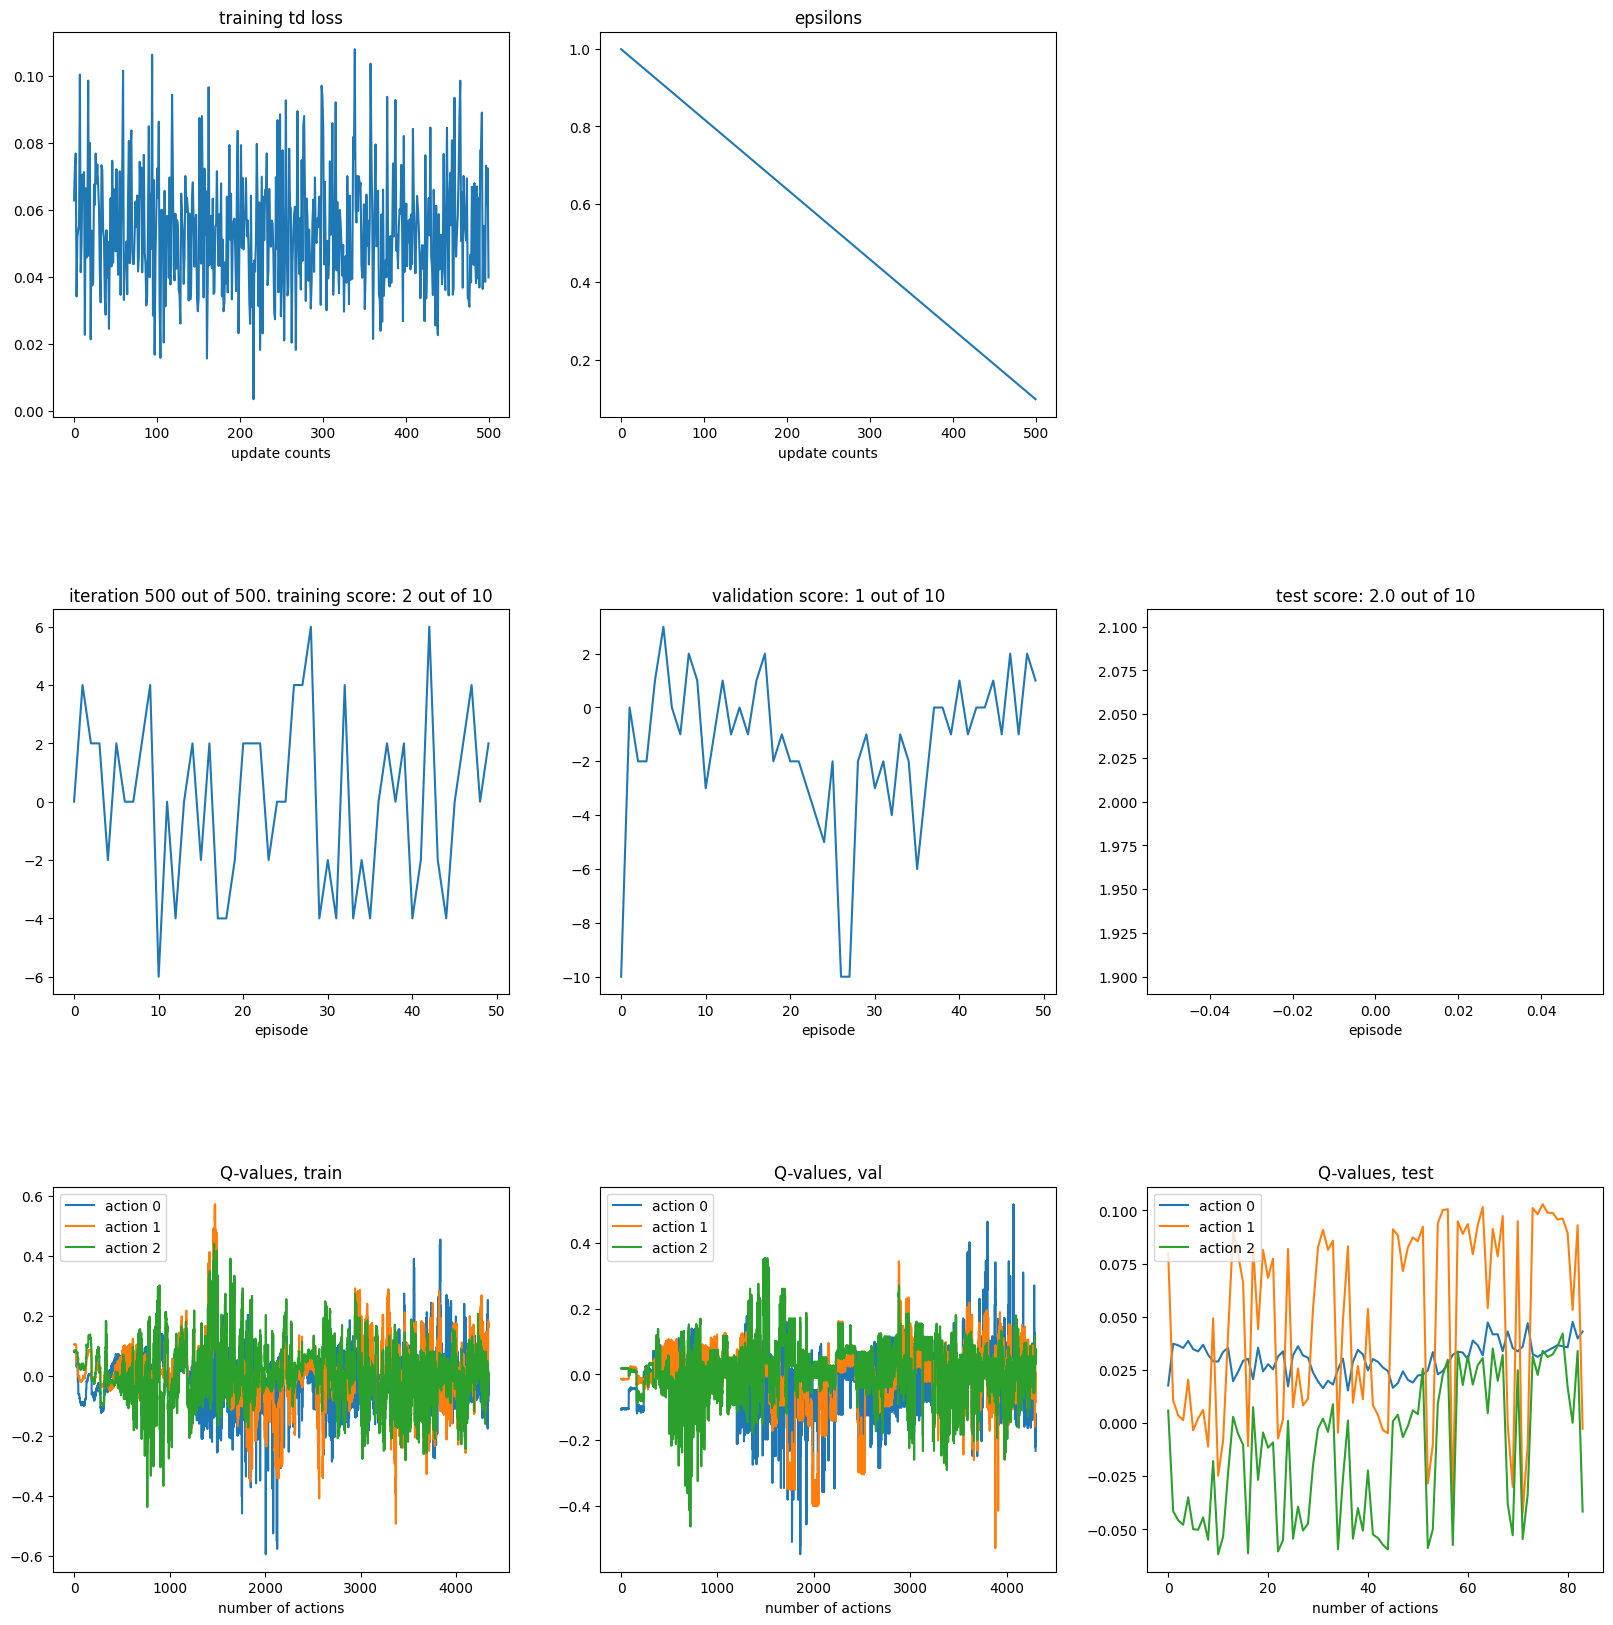

In [2]:
%matplotlib inline
from explicit_memory.utils import read_yaml, read_pickle
agent = read_pickle("./training_results/2023-11-27 10:41:11.751679/agent.pkl")
agent.plot_results("all")

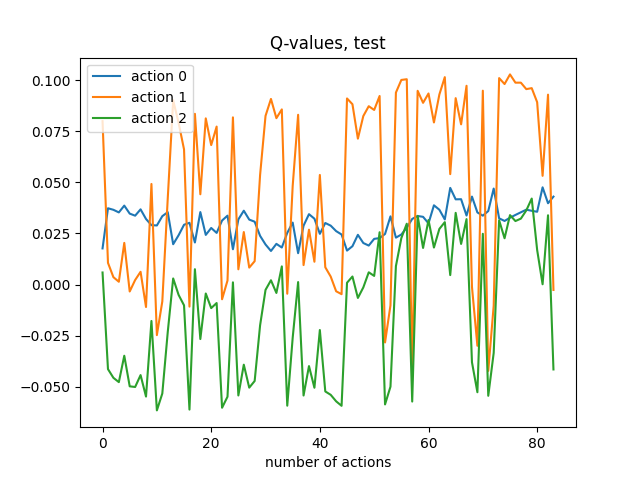

In [2]:
%matplotlib widget
agent.plot_results("q_values_test")

In [ ]:
agent.all_params

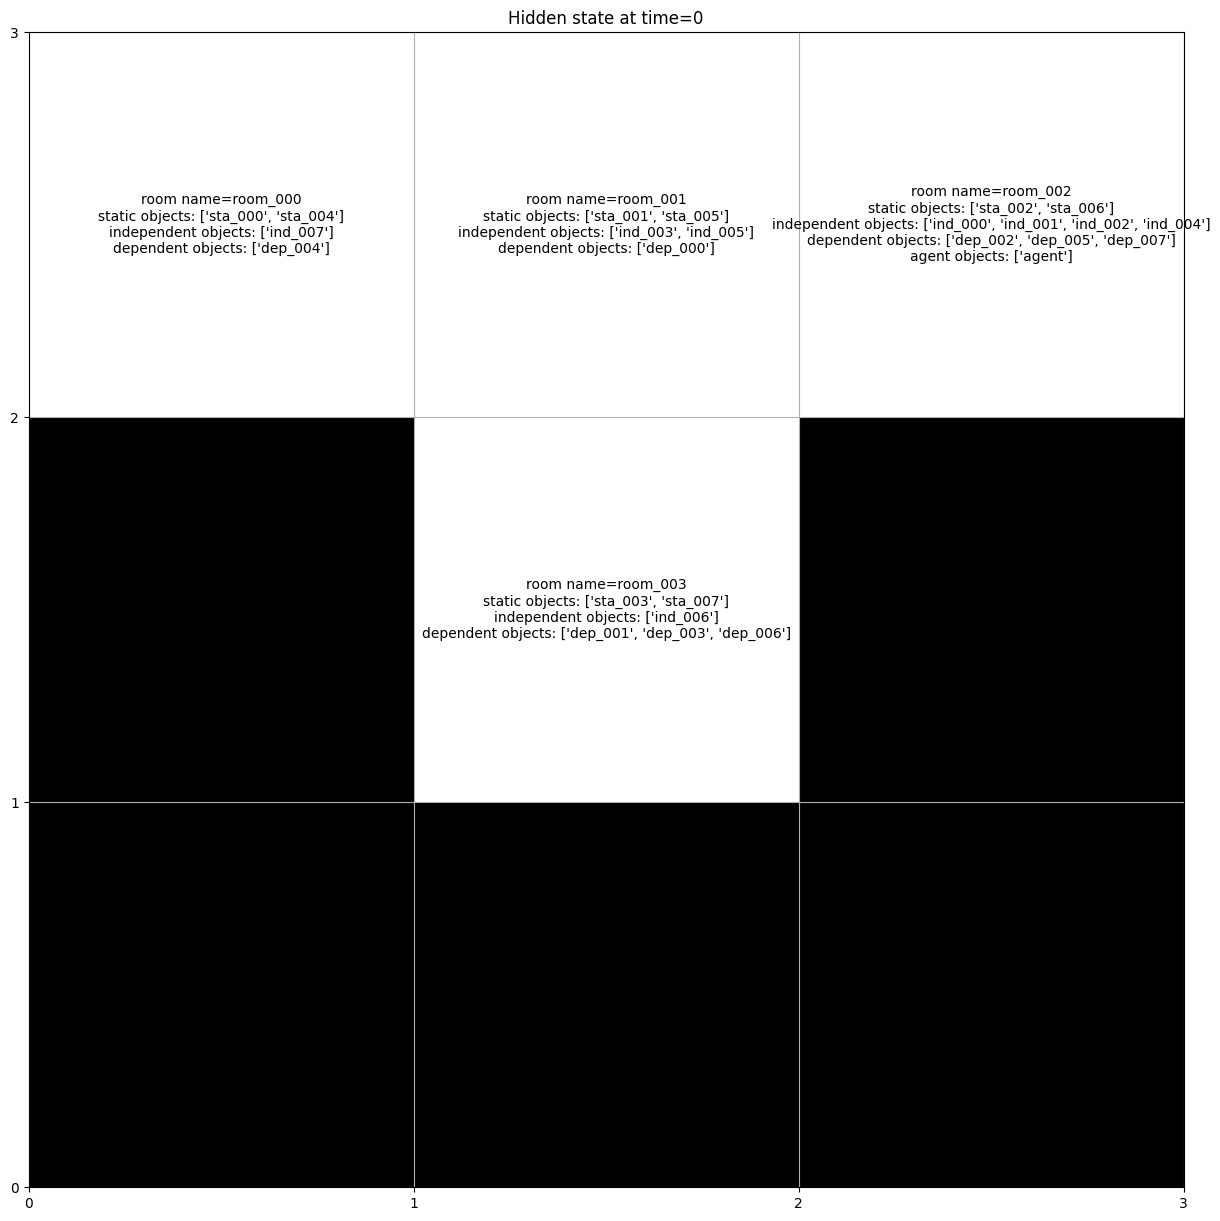

The number of room: 4
The number of static_objects: 8
The number of independent_objects: 8
The number of dependent_objects: 8

memory mgmt         qa                  explore             pretrain_semantic   mean      std       
--------------------------------------------------------------------------------------------------------------
random              episodic_semantic   avoid_walls         False               0.08      0.65      
random              episodic_semantic   random              False               -1.6      0.46      
episodic            episodic_semantic   avoid_walls         False               -1.72     1.81      
episodic            episodic_semantic   random              False               -3.56     0.46      
semantic            episodic_semantic   avoid_walls         False               -0.2      1.77      
semantic            episodic_semantic   random              False               -2.48     0.78      


In [1]:
%matplotlib inline
from agent import HandcraftedAgent
from tqdm.auto import tqdm
import numpy as np
import random
import logging
from room_env.envs.room2 import RoomEnv2

logger = logging.getLogger()
logger.disabled = True

room_size = "m"

capacity = {
    "episodic": 16,
    "episodic_agent": 16,
    "semantic": 16,
    "semantic_map": 16,
    "short": 1,
}

config = {
    "question_prob": 1.0,
    "seed": 0,
    "terminates_at": 9,
    "randomize_observations": True,
    "room_size": room_size,
    "deterministic_init": True,
}

results = {}

for mm_policy in ["random", "episodic", "semantic"]:
    for qa_policy in ["episodic_semantic"]:
        for explore_policy in ["avoid_walls", "random"]:
            for pretrain_semantic in [False]:
                key = (
                    mm_policy,
                    qa_policy,
                    explore_policy,
                    pretrain_semantic,
                )
                if key not in results:
                    results[key] = []
                print(key)

                for seed in tqdm([0, 1, 2, 3, 4]):
                    config["seed"] = seed

                    agent = HandcraftedAgent(
                        env_str="room_env:RoomEnv-v2",
                        env_config=config,
                        mm_policy=mm_policy,
                        qa_policy=qa_policy,
                        explore_policy=explore_policy,
                        num_samples_for_results=10,
                        capacity=capacity,
                        pretrain_semantic=pretrain_semantic,
                        default_root_dir= "./training_results/TRASH",
                    )
                    agent.test()
                    agent.remove_results_from_disk()
                    to_append = (np.mean(agent.scores), np.std(agent.scores))
                    # print(to_append)
                    results[key].append(to_append)


env = RoomEnv2(**config)
observations, info = env.reset()
env.render("image")
for key, val in env.names.items():
    print(f"The number of {key}: {len(val)}")

print(
    f"\n{'memory mgmt':<20}{'qa':<20}{'explore':<20}{'pretrain_semantic':<20}{'mean':<10}{'std':<10}"
)
print(f"-" * 110)
for key, val in results.items():
    print(
        f"{str(key[0]):<20}{str(key[1]):<20}{str(key[2]):<20}{str(key[3]):<20}{round(np.mean([v[0] for v in val]), 2):<10}{round(np.std([v[0] for v in val]), 2):<10}"
    )

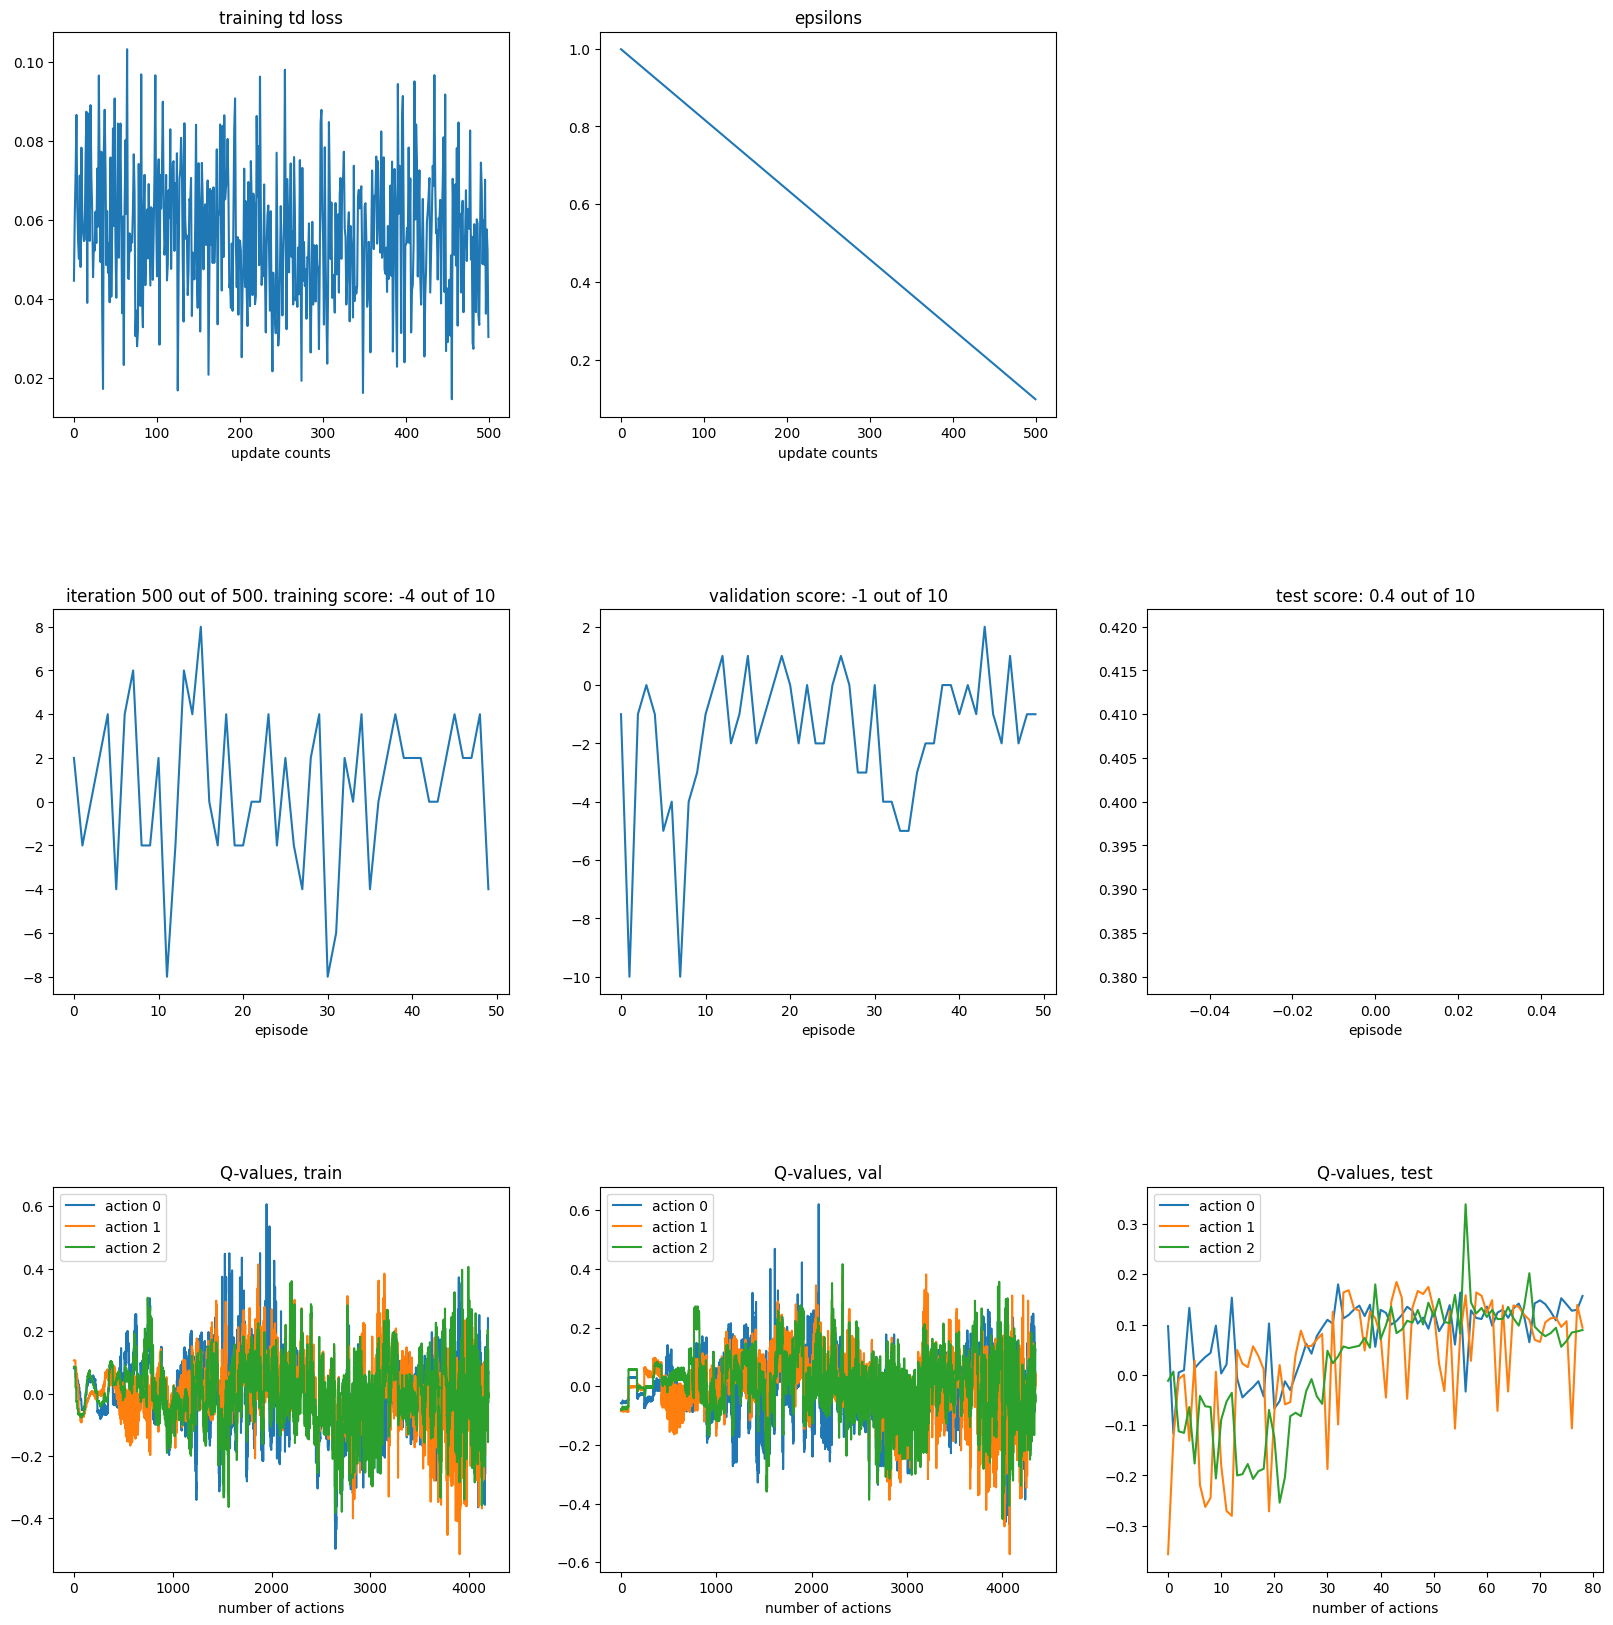

In [15]:
from agent.dqn import DQNMMAgent
import random
import logging

logger = logging.getLogger()
logger.disabled = True

for gamma in [0.20706145402209086, 0, 0.5, 0.99]:
    all_params = {
        "env_str": "room_env:RoomEnv-v2",
        "max_epsilon": 1.0,
        "min_epsilon": 0.1,
        "epsilon_decay_until": 10 * 50,
        "gamma": 0.20706145402209086,
        "capacity": capacity,
        "nn_params": {
            "hidden_size": 64,
            "num_layers": 2,
            "embedding_dim": 32,
            "v1_params": None,
            "v2_params": {},
            "memory_of_interest": [
                "episodic",
                "semantic",
                "short",
            ],
        },
        "num_iterations": 10 * 50,
        "replay_buffer_size": 512,
        "warm_start": 256,
        "batch_size": 64,
        "target_update_rate": 45,
        "pretrain_semantic": False,
        "run_test": True,
        "num_samples_for_results": 10,
        "train_seed": 5,
        "plotting_interval": 10,
        "device": "cpu",
        "test_seed": 0,
        "qa_policy": "episodic_semantic",
        "explore_policy": "avoid_walls",
        "env_config": config,
        "ddqn": False,
        "dueling_dqn": True,
        "split_reward_training": False,
        "default_root_dir": "./training_results/27-Nov-2023-supervision/",
    }

    agent = DQNMMAgent(**all_params)
    agent.train()